# Template for Accuracy Calculation for LLaMA-2 and OASST-LLAMA finetuned and zero-shot models

This script allows you to calculate accuracy scores for the results of fine-tuned and zero-shot models. Especially for zero-shot predictions, you need to re-map the output of the model to match with the labels of the original data to calculate accurate metrics, as the output might add additional words or rephrase the output. If your task is not one of the tasks that we provide, you might need to add the mapping functions yourself by inspecting the output of your predictions (e.g. you can print all the unique combinations of output and original labels to see which categories have been created.) 

### Import all Modules

In [1]:
import os
import sys
module_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(module_dir, os.pardir, "utils")))

In [2]:
import os
import re
import glob

import numpy as np
import pandas as pd 
from IPython.core.display import Markdown


from dataload_utils import  load_dataset_task_prompt_mappings
from label_utils import plot_count_and_normalized_confusion_matrix_by_class, map_label_to_completion

c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Utility Functions

In [3]:
def map_outputs_task_1(output):
    # Check first if it matches with the start of the sentence
    if re.search(r'^(\s)*RELEVANT', output.strip()):
        return 'RELEVANT'
    elif re.search(r'^(\s)*IRRELEVANT', output.strip()):
        return 'IRRELEVANT'
    elif re.search(r'\s(RELEVANT|RE|RELEVENT|RELEVAL|relevant|RELEV)', output.strip()):
        return 'RELEVANT'
    elif re.search(r'IRRELEVANT|IRRELE|does not mention|does not seem to refer ', output.strip()):
        return 'IRRELEVANT'
    elif output == np.nan or output == 'nan':
        return "NAN"
    else:
        print(f'Weird value: {output.strip()}')
        return "NAN"

In [4]:
def map_outputs_task_2(output):
    if re.search(r'^(\s)*(PROBLEM|Problem)', output.strip()):
        return 'PROBLEM'
    elif re.search(r'^(\s)*(SOLUTION|Solution)', output.strip()):
        return 'SOLUTION'
    elif re.search(r'(BOTH|Both)', output.strip()):
        return 'BOTH'
    elif re.search(r'^(\s)*(NEITHER|NEUTRAL|Neither)|Therefore, I would classify this tweet as NEUTRAL|I think it is NEUTRAL', output.strip()):
        return 'NEITHER'
    elif re.search(r'Problem|PROBLEM|(t|T)he tweet describes content moderation as a problem|'
                 r'described as a problem', output.strip()):
        return 'PROBLEM'
    elif re.search(r'SOLUTION|Solution', output.strip()):
        return 'SOLUTION'
    elif re.search(r'(NEITHER|Neither|NEUTRAL|NE|neutral)', output.strip()):
        return 'NEITHER'
    elif re.search(r'I cannot provide a classification|I cannot classify|This text does not exhibit a distinct problem or solution frame', output.strip()):
        return "NAN"
    elif output == np.nan or output == 'nan':
        return "NAN"
    else:
        print(f'Weird value: {output.strip()}')
        return "NAN"

In [5]:
def map_outputs_task_3(output):
    if re.search(r'^(\s*A:){0,1}(\s)*ECONOMY', output.strip()):
        return 'ECONOMY'

    elif re.search(r'^(\s*B:){0,1}(\s)*MORALITY', output.strip()):
        return 'MORALITY'

    elif re.search(r'^(\s*C:){0,1}(\s)*FAIRNESS AND EQUALITY', output.strip()):
        return 'FAIRNESS AND EQUALITY'

    elif re.search(r'^(\s*D:){0,1}(\s)*POLICY PRESCRIPTION AND EVALUATION', output.strip()):
        return 'POLICY PRESCRIPTION AND EVALUATION'

    elif re.search(r'^(\s*E:){0,1}(\s)*LAW AND ORDER, CRIME AND JUSTICE', output.strip()):
        return 'LAW AND ORDER, CRIME AND JUSTICE'

    elif re.search(r'^(\s*F:){0,1}(\s)*SECURITY AND DEFENSE', output.strip()):
        return 'SECURITY AND DEFENSE'

    elif re.search(r'^(\s*G:){0,1}(\s)*HEALTH AND SAFETY', output.strip()):
        return 'HEALTH AND SAFETY'

    elif re.search(r'^(\s*H:){0,1}(\s)*QUALITY OF LIFE', output.strip()):
        return 'QUALITY OF LIFE'

    elif re.search(r'^(\s*I:){0,1}(\s)*POLITICAL', output.strip()):
        return 'POLITICAL'

    elif re.search(r'^(\s*J:){0,1}(\s)*EXTERNAL REGULATION AND REPUTATION', output.strip()):
        return 'EXTERNAL REGULATION AND REPUTATION'

    elif re.search(r'^(\s*K:){0,1}(\s)*OTHER', output.strip()):
        return 'OTHER'
    
    elif re.search(r'(\s*A:){0,1}(\s)*ECONOMY|^\s*A|ECONEY', output.strip()):
        return 'ECONOMY'

    elif re.search(r'(\s*B:){0,1}(\s)*MORALITY|^\s*B(\s+|$)', output.strip()):
        return 'MORALITY'

    elif re.search(r'(\s*C:){0,1}(\s)*FAIRNESS AND EQUALITY|EQUALITY AND FAIRNESS|FAIRNESS|It is concerned with the fairness and equality', output.strip()):
        return 'FAIRNESS AND EQUALITY'

    elif re.search(r'(\s*D:){0,1}(\s)*POLICY PRESCRIPTION AND EVALUATION', output.strip()):
        return 'POLICY PRESCRIPTION AND EVALUATION'

    elif re.search(r'(\s*E:){0,1}(\s)*LAW AND ORDER(, CRIME AND JUSTICE){0,1}', output.strip()):
        return 'LAW AND ORDER, CRIME AND JUSTICE'

    elif re.search(r'(\s*F:){0,1}(\s)*SECURITY AND DEFENSE', output.strip()):
        return 'SECURITY AND DEFENSE'

    elif re.search(r'(\s*G:){0,1}(\s)*HEALTH AND SAFETY', output.strip()):
        return 'HEALTH AND SAFETY'

    elif re.search(r'(\s*H:){0,1}(\s)*QUALITY OF LIFE|^\s*H.|quality of life|H]', output.strip()):
        return 'QUALITY OF LIFE'

    elif re.search(r'(\s*I:){0,1}(\s)*(POLITICAL|POLICITAL|POLIT)', output.strip()):
        return 'POLITICAL'

    elif re.search(r'(\s*J:){0,1}(\s)*EXTERNAL REGULATION AND REPUTATION', output.strip()):
        return 'EXTERNAL REGULATION AND REPUTATION'

    elif re.search(r'(\s*K:){0,1}(\s)*OTHER|EDUCATION|does not seem to fit into|does not fit neatly into|None of the above|^\s*Other\s*$', output.strip()):
        return 'OTHER'

    elif output == np.nan or output == 'nan':
        return "NAN"

    else:
        print(f'Weird value: {output.strip()}')
        return "NAN"

In [6]:
def map_outputs_task_4(output):
    if re.search(r'^(\s)*IN FAVOR OF', output.strip()):
        return 'IN FAVOR OF'

    elif re.search(r'^(\s)*AGAINST', output.strip()):
        return 'AGAINST'

    elif re.search(r'^(\s)*NEITHER', output.strip()):
        return 'NEITHER'
    
    elif re.search(r'IN FAVOR OF|IN FAV', output.strip()):
        return 'IN FAVOR OF'

    elif re.search(r'AGAINST', output.strip()):
        return 'AGAINST'

    elif re.search(r'NEUTRAL|(without|not) express(ing){0,1} approval or disapproval|^NEUT$', output.strip()):
        return 'NEITHER'

    elif output == np.nan or output == 'nan':
        return "NAN"

    else:
        print(f'Weird value: {output.strip()}')
        return "NAN"

In [7]:
def map_outputs_task_5(output):
    if re.search(r'^(the tweet is (about (the){0,1})){0,1}(\s)*section 230', output.lower().strip()):
        return 'Section 230'

    elif re.search(r'^(the tweet is about (the){0,1}){0,1}(\s)*trump ban', output.lower().strip()):
        return 'Trump ban'

    elif re.search(r'^(the tweet is about (the){0,1}){0,1}(\s)*twitter support', output.lower().strip()):
        return 'Twitter Support'

    elif re.search(r'^(the tweet is about (the){0,1}){0,1}(\s)*platform policies', output.lower().strip()):
        return 'Platform Policies'

    elif re.search(r'^(the tweet is about (the){0,1}){0,1}(\s)*complaint', output.lower().strip()):
        return 'Complaint'

    elif re.search('^(the tweet is about (the){0,1}){0,1}(\s)*other', output.lower().strip()):
        return 'Other'
    
    elif re.search('OTHER|Therefore, it (should|can) be classified as "Other.|Other"',
                   output.strip()):
        return 'Other'
    
    elif re.search(r'SECTION 230|classified as A: Section 230|"Section 230"|A: Section 2', output.strip()):
         return 'Section 230'

    elif re.search(r'TRUMP BAN|Trump Ban|B: Trump ban|B Trump ban|B(\s+|$)|B (Trump ban)', output.strip()):
        return 'Trump ban'

    elif re.search(r'TWITTER SUPPORT|classified as C \(Twitter Support\).', output.strip()):
        return 'Twitter Support'

    elif re.search(r'PLATFORM POLICIES|Platform Policies', output.strip()):
        return 'Platform Policies'

    elif re.search(r'COMPLAINT|E: Complaint|"Complaints"|E \(Complaint\)|E(\s+|$)|classified as \(E\) Complaint', output.strip()):
        return 'Complaint'

    elif output == np.nan or output == 'nan':
        return "NAN"

    else:
        print(f'Weird value: {output.strip()}')
        return 'Other'

In [8]:
def map_outputs_task_6(output):
    if re.search(r'^(\s*A:){0,1}(\s)*POLICY AND REGULATION', output.strip()):
        return 'POLICY AND REGULATION'
    
    elif re.search(r'^(\s*B:){0,1}(\s)*MORALITY AND LAW', output.strip()):
        return 'MORALITY AND LAW'
    
    elif re.search(r'^(\s*C:){0,1}(\s)*ECONOMICS', output.strip()):
        return 'ECONOMICS'
    
    elif re.search(r'^(\sD:){0,1}(\s)*OTHER', output.strip()):
        return 'OTHER'

    elif re.search(r'(\s*C:){0,1}(\s)*ECONOM(Y|ICS)|^\s*A', output.strip()):
        return 'ECONOMICS'
    
    elif re.search(r'(\s*C:){0,1}(\s)*PUBLIC OPINION|^\s*A', output.strip()):
        return 'ECONOMICS'

    elif re.search(r'(\s*B:){0,1}(\s)*MORALITY|^\s*B(\s+|$)', output.strip()):
        return 'MORALITY AND LAW'

    elif re.search(r'(\s*B:){0,1}(\s)*FAIRNESS AND EQUALITY', output.strip()):
        return 'MORALITY AND LAW'

    elif re.search(r'(\s*A:){0,1}(\s)*POLICY PRESCRIPTION AND EVALUATION|POLICY AND REGULATION', output.strip()):
        return 'POLICY AND REGULATION'

    elif re.search(r'(\s*B:){0,1}(\s)*LAW AND ORDER, CRIME AND JUSTICE', output.strip()):
        return 'MORALITY AND LAW'
    
    elif re.search(r'(\s*B:){0,1}(\s)*CONSTITUTIONALITY AND JURISPRUDENCE', output.strip()):
        return 'MORALITY AND LAW'

    elif re.search(r'(\s*C:){0,1}(\s)*SECURITY AND DEFENSE', output.strip()):
        return 'CAPACITY AND RESOURCES'

    elif re.search(r'(\s*B:){0,1}(\s)*HEALTH AND SAFETY', output.strip()):
        return 'MORALITY AND LAW'

    elif re.search(r'(\sC:){0,1}(\s)*QUALITY OF LIFE', output.strip()):
        return 'ECONOMICS'
    
    elif re.search(r'(\sC:){0,1}(\s)*CAPACITY AND RESOURCES', output.strip()):
        return 'ECONOMICS'

    elif re.search(r'(\s*A:){0,1}(\s)*(POLITICAL|POLICITAL)', output.strip()):
        return 'POLICY AND REGULATION'

    elif re.search(r'(\s*A:){0,1}(\s)*EXTERNAL REGULATION AND REPUTATION', output.strip()):
        return 'POLICY AND REGULATION'

    elif re.search(r'(\s*D:){0,1}(\s)*OTHER|EDUCATION|^E: SOCIAL MEDIA', output.strip()):
        return 'OTHER'

    elif output == np.nan or output == 'nan':
        return "NAN"

    else:
        print(f'Weird value: {output.strip()}')
        return "NAN"

In [9]:
map_to_task_label_processing_fn = {
    1: map_outputs_task_1,
    2: map_outputs_task_2,
    3: map_outputs_task_3,
    4: map_outputs_task_4,
    5: map_outputs_task_5,
    6: map_outputs_task_6
    #YOU MIGHT NEED TO ADD YOUR TASK HERE
}

In [10]:
def process_output_llama2(output_str, task_num):
    # Remove the prompt: FOR META-LLAMA MODELS
    output_str = ' '.join(output_str.split('[/INST] ')[-1:])

    # process accordin to the task_num
    return map_to_task_label_processing_fn[task_num](output_str)

In [11]:
def process_output_llama3(output_str, task_num):
    # Remove the prompt: FOR META-LLAMA MODELS
    output_str = ' '.join(output_str.split('assistant\n\n')[-1:])

    # process accordin to the task_num
    return map_to_task_label_processing_fn[task_num](output_str)

In [12]:
def process_output_oasst(output_str, task_num):
    # Remove the prompt
    output_str = ' '.join(output_str.split('<|endoftext|>')[1:])
    
    # process accordin to the task_num
    return map_to_task_label_processing_fn[task_num](output_str)

In [13]:
process_output = {
    "llama3": process_output_llama3,
    "llama2": process_output_llama2,
    "oasst": process_output_oasst
    #YOU MIGHT NEED TO ADD YOUR TASK HERE
}

### Set Up Arguments and Data

Here, you define the values for the dataset that you are loading:

In [14]:
#Configuration variables

#Name of the file to compute accuracy for
prediction_file_name = "../../data/predictions/meta-llama_Meta-Llama-3-8B-Instruct/meta-llama_Meta-Llama-3-8B-Instruct_ds_5_task_2_sample_0_prompt_max_len_4096.csv"

#Path to the dataset-task mappings file
dataset_task_mappings_fp = os.path.normpath(os.path.join('..', '..', 'dataset_task_mappings.csv'))

# Type of task to run inference on
task = 2  # Choices: [1,2,3,4,5,6]

# Dataset to run inference on
dataset = 5  # 

# Size of the sample to generate
sample_size = '0'  # Enter 0 for zero-shot predictions

# Zero-shot
zero_shot = True

#Meta (set False for Oasst)
llama_version = "llama3"

## Main Implementation

In [15]:
#load the file with predictions
df = pd.read_csv(prediction_file_name)

In [16]:
dataset_task_mappings_fp = os.path.join('..', '..', 'dataset_task_mappings.csv')

# Get the expected labelset
dataset_idx, dataset_task_mappings = load_dataset_task_prompt_mappings(
    dataset_num=dataset, task_num=task, dataset_task_mappings_fp=dataset_task_mappings_fp)
label_column = dataset_task_mappings.loc[dataset_idx, "label_column"]
labelset = dataset_task_mappings.loc[dataset_idx, "labelset_fullword"].split("; ")
labelset = [label.strip() for label in labelset]
labelset = [label.upper() for label in labelset] 

In [17]:
accuracy_summary_list = []

Weird value: I cannot determine whether the text exhibits a problem or solution frame as it appears to be an advertisement for a webcam service and contains explicit content.
results for dataset 1
Weird value: I cannot determine whether the text exhibits a problem or solution frame as it appears to be an advertisement for a webcam service and contains explicit content.
{'BOTH': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 3.0},
 'NAN': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 0.0},
 'NEITHER': {'f1-score': 0.15602836879432624,
             'precision': 1.0,
             'recall': 0.08461538461538462,
             'support': 260.0},
 'PROBLEM': {'f1-score': 0.20408163265306123,
             'precision': 0.11363636363636363,
             'recall': 1.0,
             'support': 35.0},
 'SOLUTION': {'f1-score': 0.03076923076923077,
              'precision': 0.07142857142857142,
              'recall': 0.0196078431372549,
              'support': 51.0},

c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c

results for dataset 2
{'BOTH': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 0.0},
 'NEITHER': {'f1-score': 0.05714285714285714,
             'precision': 0.8,
             'recall': 0.02962962962962963,
             'support': 135.0},
 'PROBLEM': {'f1-score': 0.1437125748502994,
             'precision': 0.07792207792207792,
             'recall': 0.9230769230769231,
             'support': 13.0},
 'SOLUTION': {'f1-score': 0.0,
              'precision': 0.0,
              'recall': 0.0,
              'support': 16.0},
 'accuracy': 0.0975609756097561,
 'macro avg': {'f1-score': 0.05021385799828913,
               'precision': 0.2194805194805195,
               'recall': 0.2381766381766382,
               'support': 164.0},
 'weighted avg': {'f1-score': 0.058430177971582974,
                  'precision': 0.6647133354450427,
                  'recall': 0.0975609756097561,
                  'support': 164.0}}


c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

results for dataset 3
{'BOTH': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 9.0},
 'NEITHER': {'f1-score': 0.0,
             'precision': 0.0,
             'recall': 0.0,
             'support': 224.0},
 'PROBLEM': {'f1-score': 0.13496932515337423,
             'precision': 0.07236842105263158,
             'recall': 1.0,
             'support': 22.0},
 'SOLUTION': {'f1-score': 0.0,
              'precision': 0.0,
              'recall': 0.0,
              'support': 50.0},
 'accuracy': 0.07213114754098361,
 'macro avg': {'f1-score': 0.03374233128834356,
               'precision': 0.018092105263157895,
               'recall': 0.25,
               'support': 305.0},
 'weighted avg': {'f1-score': 0.009735492306145026,
                  'precision': 0.005220017256255392,
                  'recall': 0.07213114754098361,
                  'support': 305.0}}
results for dataset 4
{'BOTH': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 4.0},
 'NEITHER': {'f1-

c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\anaconda3\envs\llm_finetune_cp\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


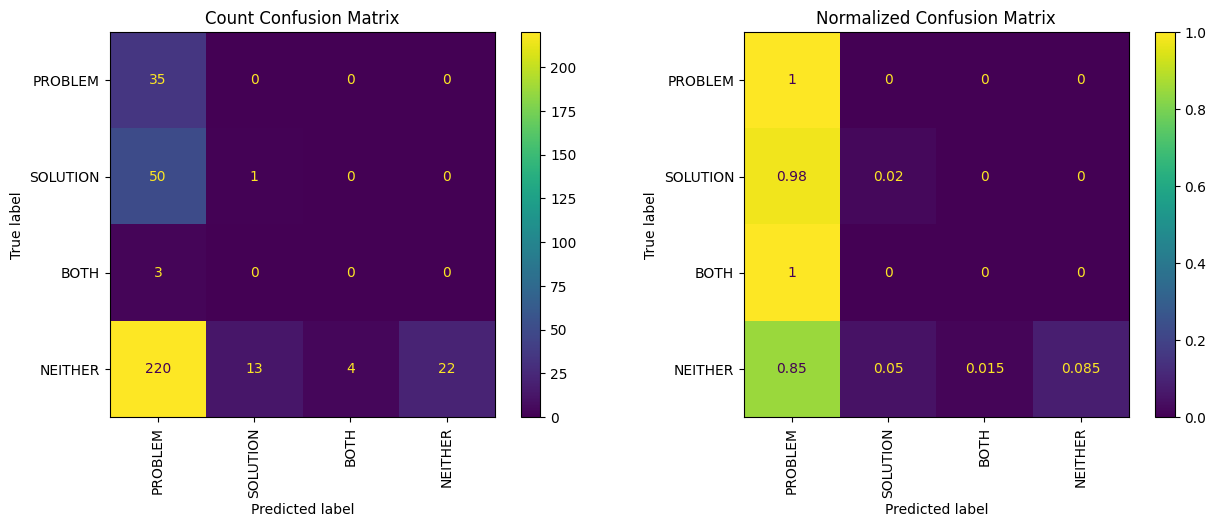

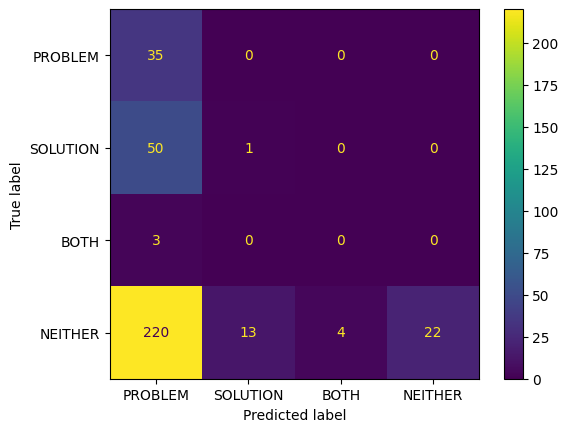

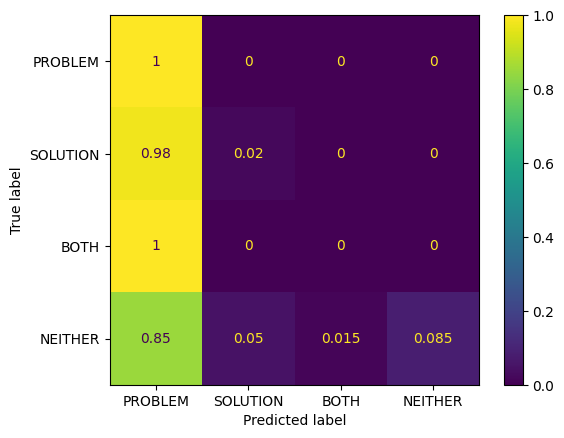

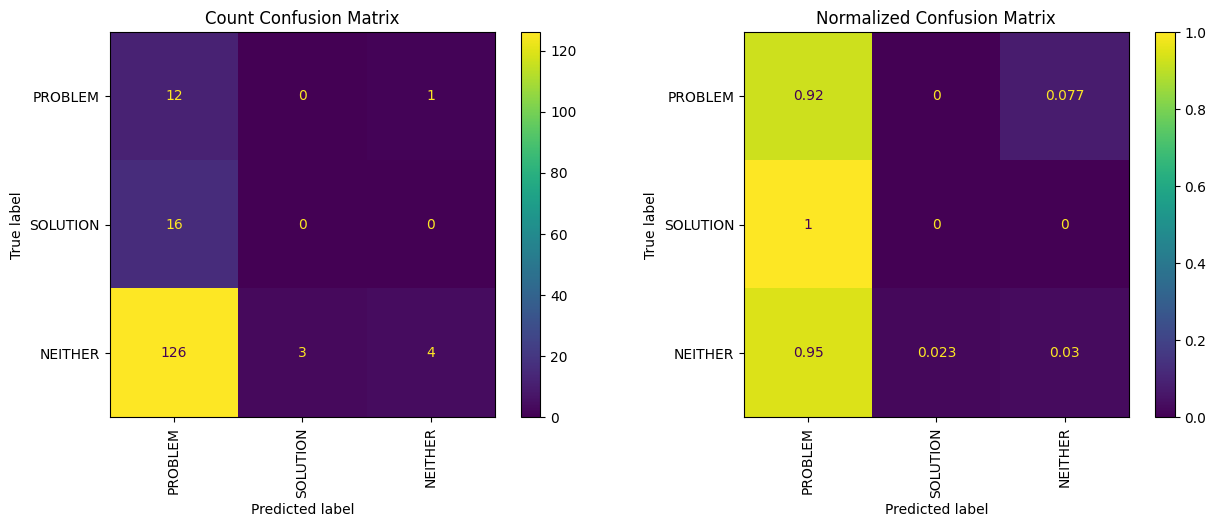

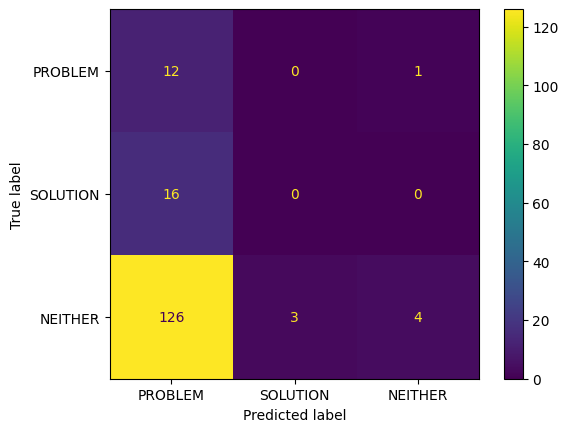

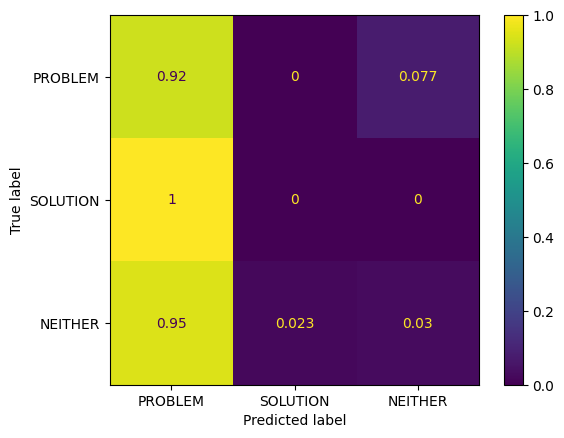

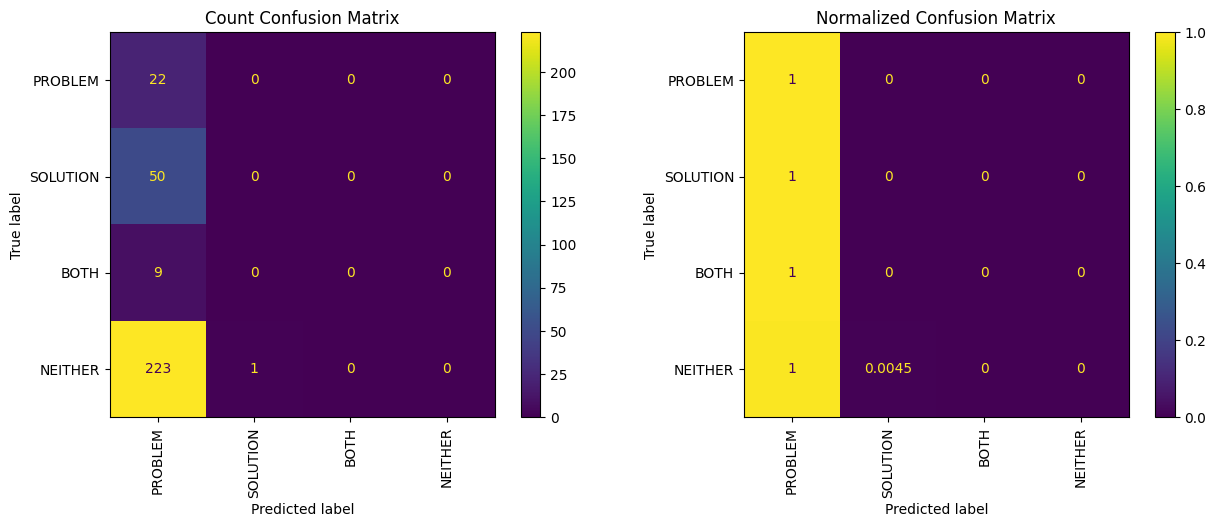

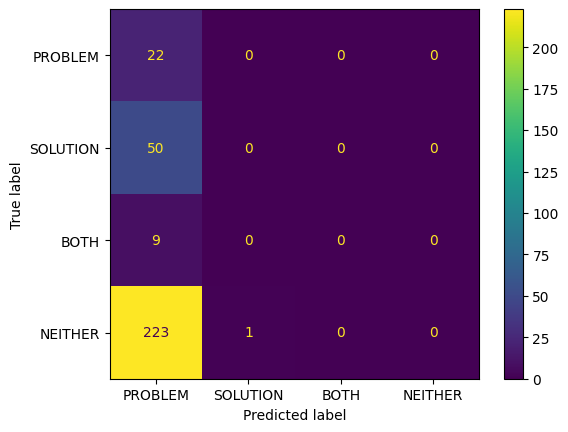

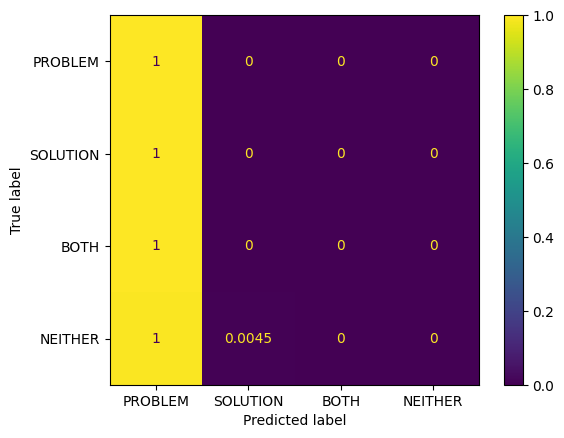

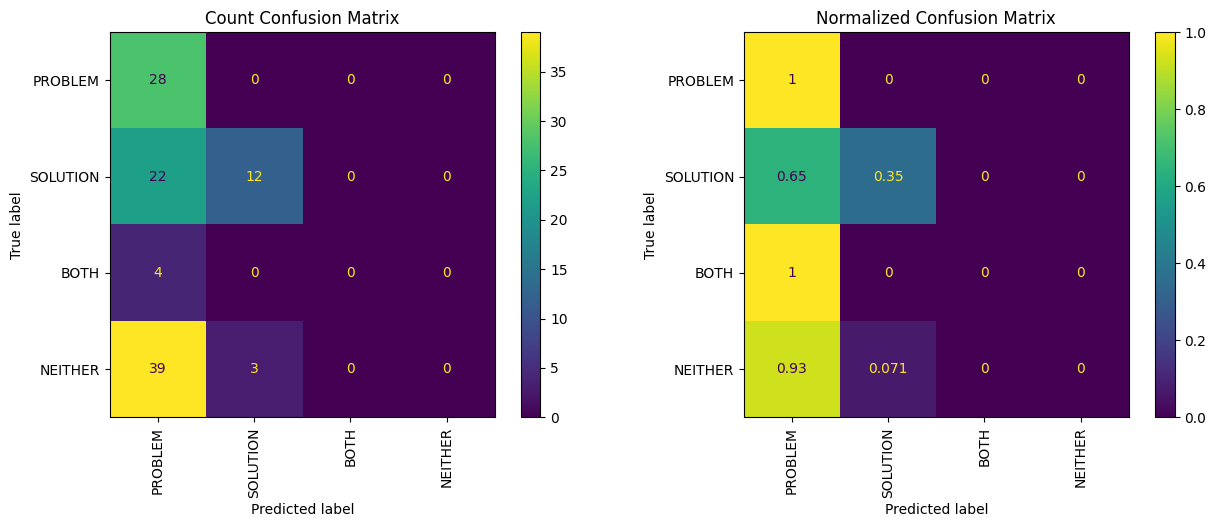

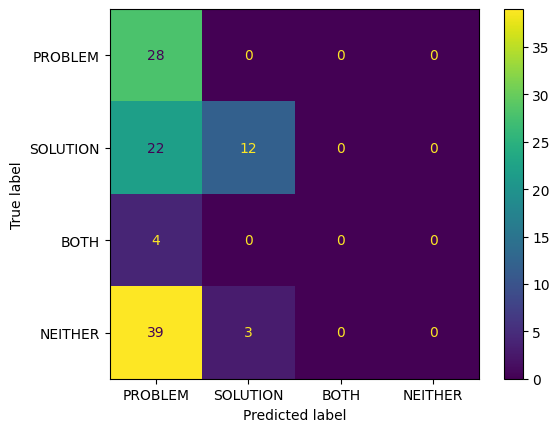

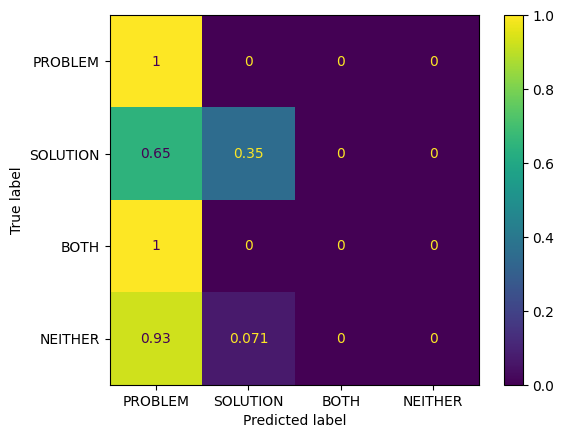

In [18]:
# Get predictions
y_pred = df.prediction.map(lambda x: process_output[llama_version](x, task))

for dataset in [1, 2, 3, 4]:
    print(f"results for dataset {dataset}")
    # Get ground truth in same format
    y_pred = df.loc[df['dataset'] == dataset, 'prediction'].map(lambda x: process_output[llama_version](x, task))
    y_true = df.loc[df['dataset'] == dataset, label_column].map(lambda label: map_label_to_completion(
        label=label, task_num=task, full_label=True))
    assert y_true.map(lambda pred: pred not in labelset).sum() == 0, 'Ground truth not in expected labelset'

    # Get accuracy
    labels = labelset
    display_labels = labelset
    cm_plot, classification_report, metrics = plot_count_and_normalized_confusion_matrix_by_class(
        y_true, y_pred, display_labels, labels, xticks_rotation='vertical')

    # Get accuracy
    # Get accuracy
    accuracy_summary_list.append({
        'dataset':  dataset,
        **metrics,
    })

In [19]:
accuracies_out = pd.DataFrame(accuracy_summary_list).set_index(['dataset',]).sort_index()

In [20]:
accuracies_out

,accuracy,recall,precision,f1,PROBLEM_precision,PROBLEM_recall,PROBLEM_f1,SOLUTION_precision,SOLUTION_recall,SOLUTION_f1,BOTH_precision,BOTH_recall,BOTH_f1,NEITHER_precision,NEITHER_recall,NEITHER_f1
dataset,,,,,,,,,,,,,,,,
1,0.166189,0.220845,0.237013,0.078176,0.113636,1.000000,0.204082,0.071429,0.019608,0.030769,0.0,0.0,0.0,1.0,0.084615,0.156028
2,0.097561,0.238177,0.219481,0.050214,0.077922,0.923077,0.143713,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.8,0.029630,0.057143
3,0.072131,0.250000,0.018092,0.033742,0.072368,1.000000,0.134969,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.370370,0.338235,0.275269,0.238151,0.301075,1.000000,0.462810,0.800000,0.352941,0.489796,0.0,0.0,0.0,0.0,0.000000,0.000000
